In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
from skimage.feature import hog
import os
import pickle
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Flatten, Dropout,Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

%matplotlib inline

Using TensorFlow backend.


In [2]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 48  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
#hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
#spatial_size = (16, 16) # Spatial binning dimensions
#hist_bins = 16    # Number of histogram bins
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
#hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

In [3]:
#hog subsampling window search

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [4]:
# testing in Keras

def nn_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(64,64,3)))
    model.add(Convolution2D(4, 5, 5))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Activation('relu'))
    
    model.add(Convolution2D(12, 5, 5))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(96))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    
    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile('rmsprop', 'binary_crossentropy', ['accuracy'])
    
    return model

"""model-good.hd5
def nn_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(64,64,3)))
    model.add(Convolution2D(4, 5, 5))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Activation('relu'))
    
    model.add(Convolution2D(12, 5, 5))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(96))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    
    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile('rmsprop', 'binary_crossentropy', ['accuracy'])
"""

"model-good.hd5\ndef nn_model():\n    model = Sequential()\n    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(64,64,3)))\n    model.add(Convolution2D(4, 5, 5))\n    model.add(MaxPooling2D((2, 2)))\n    \n    model.add(Activation('relu'))\n    \n    model.add(Convolution2D(12, 5, 5))\n    model.add(MaxPooling2D((2, 2)))\n    \n    model.add(Activation('relu'))\n    \n    model.add(Flatten())\n    model.add(Dense(96))\n    model.add(Dropout(0.5))\n    model.add(Activation('relu'))\n    \n    model.add(Dense(64))\n    model.add(Dropout(0.5))\n    model.add(Activation('relu'))\n    \n    model.add(Dense(1))\n    model.add(Activation('sigmoid'))\n    model.compile('rmsprop', 'binary_crossentropy', ['accuracy'])\n"

In [ ]:
# search and classify

# Read in cars and notcars
images = glob.glob('./vehicles_smallset/*.jpeg')
print (len(images))
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        dis_img = mpimg.imread(image)
        dat_img = convert_color(dis_img, conv='RGB2YCrCb')
        notcars.append(dat_img)
        
        dis_img = np.fliplr(dis_img)
        dat_img = convert_color(dis_img, conv='RGB2YCrCb')
        notcars.append(dat_img)
    else:
        dis_img = mpimg.imread(image)
        dat_img = convert_color(dis_img, conv='RGB2YCrCb')
        cars.append(dat_img)
        
        dis_img = np.fliplr(dis_img)
        dat_img = convert_color(dis_img, conv='RGB2YCrCb')
        cars.append(dat_img)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 750
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
X_train = np.concatenate((cars, notcars), axis=0)

y_train = np.hstack((np.ones(len(cars)), np.zeros(len(notcars)))).reshape(-1,1)

model = nn_model()
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)

model.save('model.h5')

print ("Model saved!")

In [5]:
# multiple detections and false positives

"""def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
"""    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [6]:
# search and classify

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [46]:
# hog subsampling window search

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[ystart, ystop], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    
    for window in windows:        
        new_X = []
        subimg = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        subimg = convert_color(subimg, conv='RGB2YCrCb')
        new_X.append(subimg)   
        new_X = np.array(new_X)

        test_prediction = model.predict(new_X, batch_size=1)
        #plt.figure()
        
        if test_prediction >= 0.7:
            heat[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    """
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            new_X = []
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
            new_X.append(subimg)   
            new_X = np.array(new_X)
            
            test_prediction = model.predict(new_X, batch_size=1)
            #plt.figure()
            #plt.imshow(subimg)
            #print (test_prediction)
            
            if test_prediction >= 0.7:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                heat[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    """
    heatmap_confidence = 0.5
    #print ("Max heatmap value: %d" % np.max(heat))
    
    if int(heatmap_confidence*np.max(heat)) >= 3:
        heat_threshold = int(heatmap_confidence*np.max(heat))
    else:
        heat_threshold = 3
    #heat_threshold = max(int(heatmap_confidence*np.max(heat), 2))
    #print ("Threshold heatmap value: %d" % heat_threshold)
    thresh_heat = apply_threshold(heat, heat_threshold)
    
    clipped_heat = np.clip(thresh_heat, 0, 255)
    #clipped_heat = np.clip(heat, 0, 255)
    #print (np.max(thresh_heat))
    labels = label(clipped_heat)
    
    ctrans_tosearch_2 = convert_color(img, conv='RGB2YCrCb')
    
    # multiple detections and false positives
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)  
        
    #plt.figure(figsize=(16,16))
    #plt.imshow(draw_img)
    
    #plt.figure(figsize=(16,16))
    #plt.imshow(clipped_heat, cmap='hot')
                
    return draw_img

In [44]:
def detection_pipeline(img):
    ystart = 300
    ystop = 656
    scale = 1

    svc = 0
    X_scaler = 0
    out_img = find_cars(img, ystart, ystop, scale)

    return out_img

Max heatmap value: 16
Threshold heatmap value: 8
Max heatmap value: 2
Threshold heatmap value: 3
Max heatmap value: 8
Threshold heatmap value: 4
Max heatmap value: 16
Threshold heatmap value: 8
Max heatmap value: 16
Threshold heatmap value: 8
Max heatmap value: 15
Threshold heatmap value: 7


"    \n\nimg = 'test3.jpg'\nimage = mpimg.imread('./test_images/' + img)\n\nprocessed_img = detection_pipeline(image)\n\nplt.imsave('output_images/' + img, processed_img)\nplt.figure(figsize=(16,16))\nplt.imshow(processed_img)\n"

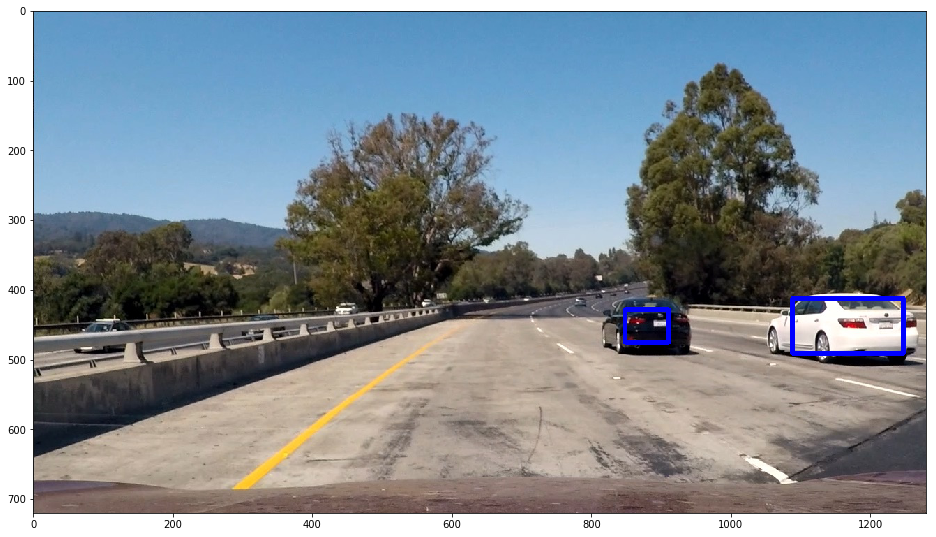

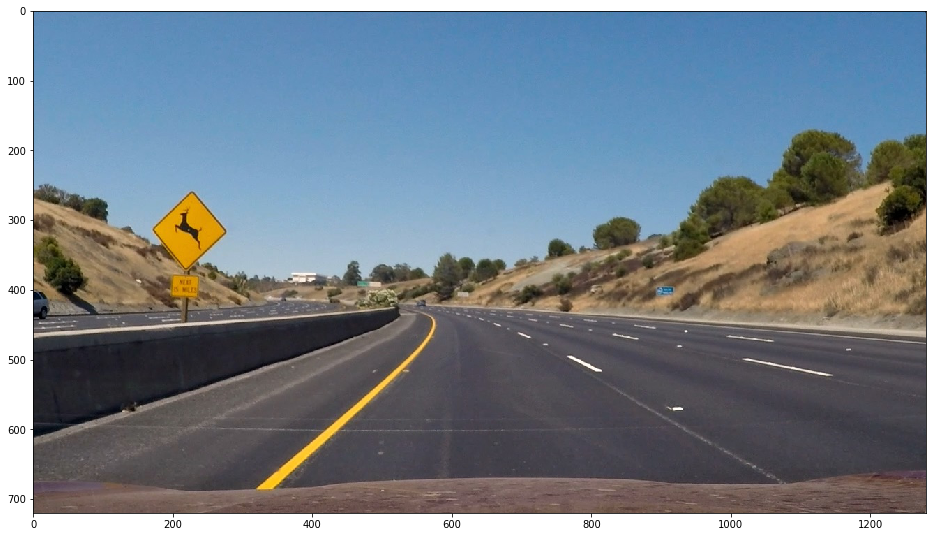

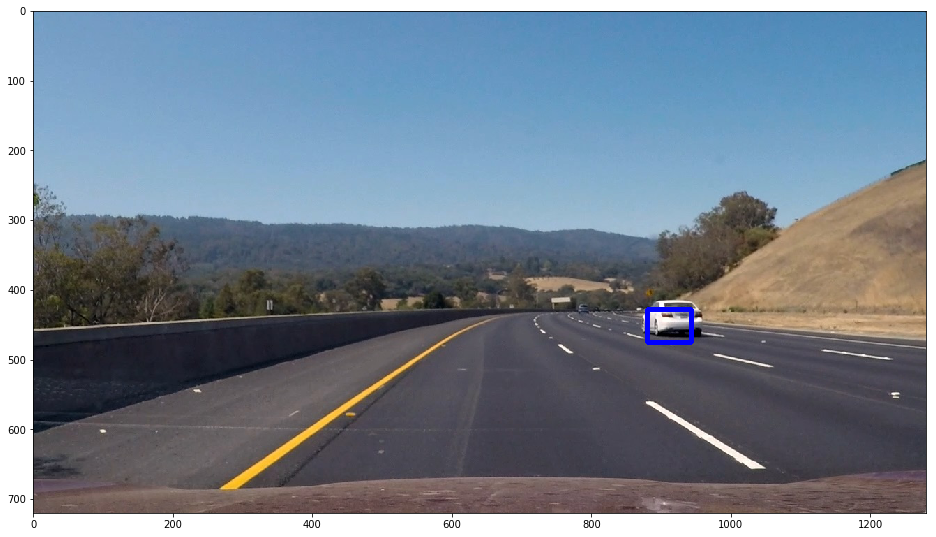

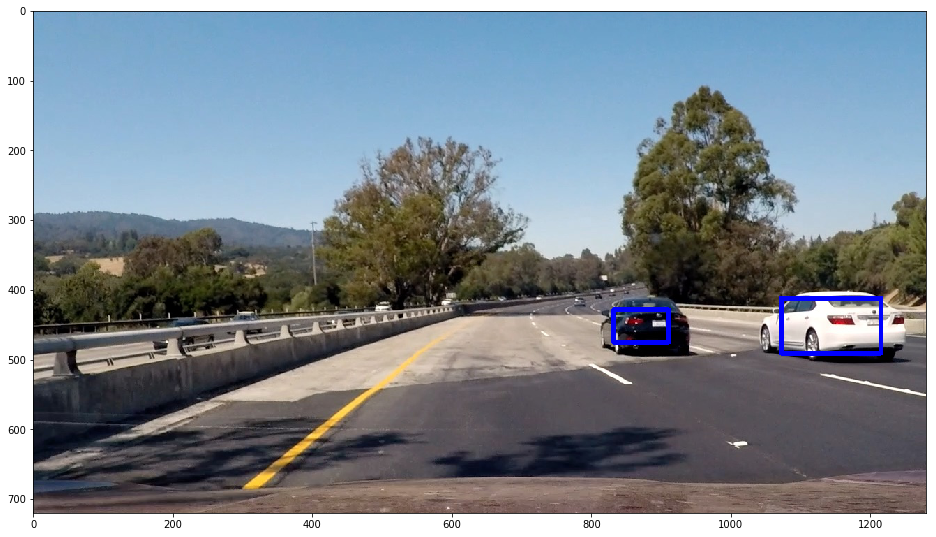

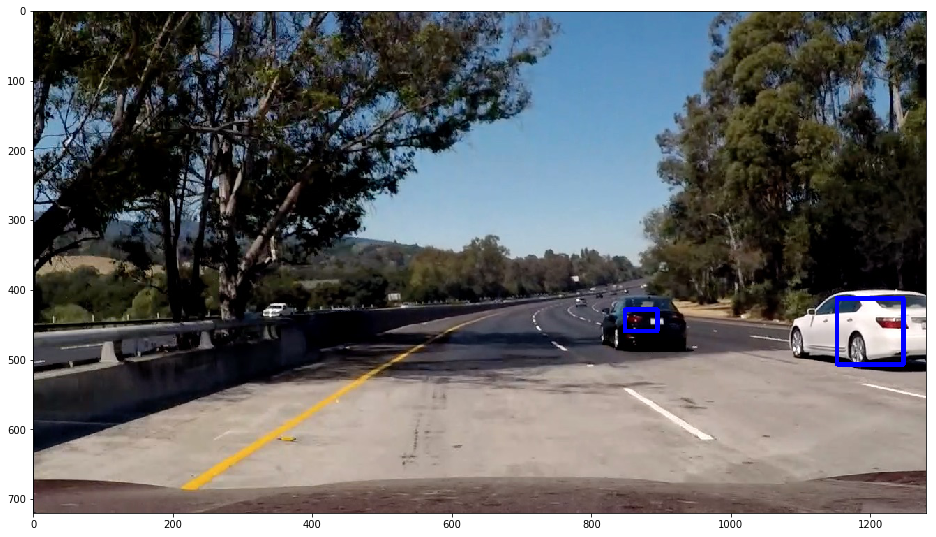

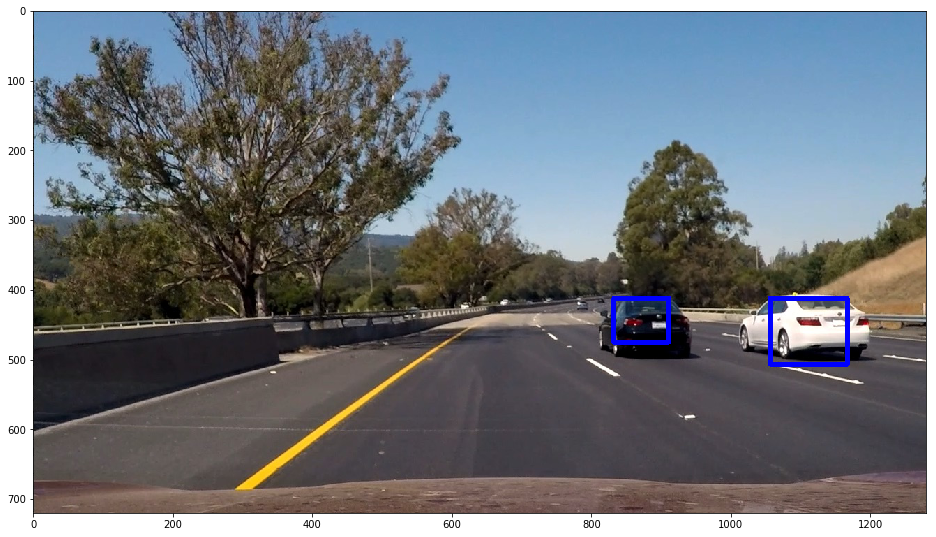

In [45]:
# static image version
# noticing lots of variations from run-to-run; probably based on the different models generated by the SVM

img_list =os.listdir("./test_images/")


for img in img_list:
    image = mpimg.imread('./test_images/' + img)

    processed_img = detection_pipeline(image)

    plt.imsave('output_images/' + img, processed_img)
    plt.figure(figsize=(16,16))
    plt.imshow(processed_img)
"""    

img = 'test3.jpg'
image = mpimg.imread('./test_images/' + img)

processed_img = detection_pipeline(image)

plt.imsave('output_images/' + img, processed_img)
plt.figure(figsize=(16,16))
plt.imshow(processed_img)
"""

In [48]:
# video clip version

#challenge_output = 'output_images/test_video.mp4'
#clip1 = VideoFileClip('test_video.mp4')
#white_clip = clip1.fl_image(detection_pipeline) #NOTE: this function expects color images!!
#white_clip.write_videofile(challenge_output, audio=False)

challenge_output = 'output_images/project_video.mp4'
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(detection_pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [51:01<00:02,  2.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 



In [10]:
# load a known good model
model = load_model('model-good.h5')